# Learning and Decision Making

## Laboratory 4: Reinforcement learning

In the end of the lab, you should export the notebook to a Python script (``File >> Download as >> Python (.py)``). Make sure that the resulting script includes all code written in the tasks marked as "**Activity n. N**", together with any replies to specific questions posed. Your file should be named `padi-labKK-groupXXX.py`, where `KK` corresponds to the lab number and the `XXX` corresponds to your group number. Similarly, your homework should consist of a single pdf file named `padi-hwKK-groupXXX.pdf`. You should create a zip file with the lab and homework files and submit it in Fenix **at most 30 minutes after your lab is over**.

Make sure to strictly respect the specifications in each activity, in terms of the intended inputs, outputs and naming conventions.

In particular, after completing the activities you should be able to replicate the examples provided (although this, in itself, is no guarantee that the activities are correctly completed).

### 1. The MDP Model 

In this lab you will implement several reinforcement learning algorithms, and use the garbage collection domain from Lab 2 to test and compare these algorithms. Don't forget, however, that your functions should work for **any MDP** and not just the one provided. 

The garbage collection domain to be used is represented in the diagram below.

<img src="garbage-big.png">

In the above domain, 

* At any time step, garbage is _at most_ in one of the cells marked with a garbage bin. 
* When the garbage truck picks up the garbage from one of the bins, it becoles ``loaded``. 
* While the truck is loaded, no garbage appears in any of the marked locations.
* The driver has six actions available: `Up`, `Down`, `Left`, `Right`, `Pick`, and `Drop`. 
* Each movement action moves the truck to the adjacent stop in the corresponding direction, if there is one. Otherwise, it has no effect. 
* The `Pick` action succeeds when the truck is in a location with garbage. In that case, the truck becomes "loaded".
* The `Drop` action succeeds when the loaded truck is at the recycling plant. After a successful drop, the truck becomes empty, and garbage may now appear in any of the marked cells with a total probability of 0.3.

**Throughout the lab, unless if stated otherwise, use $\gamma=0.99$.**

$$\diamond$$

We start by loading the MDP for the garbage collection domain from the file `garbage.npz`. We will use this domain as an example to illustrate the different functions/algorithms you are expected to deploy. The file contains both the MDP, described as a tuple like those from Lab 2, and the corresponding optimal $Q$-function.

To do so, you can run the code
```python
import numpy as np

mdp_info = np.load('garbage.npz', allow_pickle=True)

# The MDP is a tuple (X, A, P, c, gamma)
M = mdp_info['M']

# We also load the optimal Q-function for the MDP
Qopt = mdp_info['Q']
```

---

In the first activity, you will implement a "simulator of the world". The simulator consists of a function that enables you to sample a transition from a given MDP. You will then use this function, in subsequent activities, to generate the data that your agent will use to learn.

---

#### Activity 1.        

Write a function named `sample_transition` that receives, as input, a tuple representing an arbitrary MDP as well as two integers, `s` and `a`, corresponding to a state and an action. The function should return a tuple `(s, a, c, s')`, where `c` is the cost associated with performing action `a` in state `s` and `s'` is a state generated from `s` upon selecting action `a`, according to the transition probabilities for the MDP.

---

In [103]:
# Insert your code here.
import numpy as np
import numpy.random as rnd

true = True
false = False

mdp_info = np.load('garbage.npz', allow_pickle=true)
M = mdp_info['M']
Qopt = mdp_info['Q']


def sample_transition(M, s, a):
    X = M[0] 
    A = M[1]
    P = M[2]
    C = M[3]
    gamma = M[4]
    
    c = C[s, a]

    s_prime = rnd.choice(len(X), p=P[a][s, :])

    output = (s, a, c, s_prime)

    return output

rnd.seed(42)

# Select random state and action
s = 115 # State (8, 28, empty)
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = 429 # (0, None, loaded)
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('\nObserved transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = 239 # State (18, 18, empty)
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('\nObserved transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')


Observed transition:
((8, 28, empty), Right, 0.501, (10, 28, empty))

Observed transition:
((0, None, loaded), Left, 1.0, (0, None, loaded))

Observed transition:
((18, 18, empty), Pick, 0.01, (18, None, loaded))


All reinforcement learning algorithms that you will implement can only access the MDP through the function `sample_transition` which, in a sense, simulates an "interaction" of the agent with the environment.

For example, using the garbage collection MDP, you could run:

```python
import numpy.random as rnd

rnd.seed(42)

# Select random state and action
s = 115 # State (8, 28, empty)
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('Observed transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = 429 # (0, None, loaded)
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('\nObserved transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')

# Select random state and action
s = 239 # State (18, 18, empty)
a = rnd.randint(len(M[1]))

s, a, cnew, snew = sample_transition(M, s, a)

print('\nObserved transition:\n(', end='')
print(M[0][s], end=', ')
print(M[1][a], end=', ')
print(cnew, end=', ')
print(M[0][snew], end=')\n')
```

and get, as output:

```
Observed transition:
((8, 28, empty), Right, 0.501, (10, 28, empty))

Observed transition:
((0, None, loaded), Left, 1.0, (0, None, loaded))

Observed transition:
((18, 18, empty), Pick, 0.01, (18, None, loaded))
```

**Note:** For debug purposes, we also provide a second file, `garbage-small.npz`, that contains a 6-state MDP that you can use to verify if your results make sense.

---

#### Activity 2.        

Write down a function named `egreedy` that implements an $\epsilon$-greedy policy. Your function should receive, as input, a `numpy` array `Q` with shape `(N,)`, for some integer `N`, and, as an optional argument, a floating point number `eps` with a default value `eps=0.1`. Your function should return... 

* ... with a probability $\epsilon$, a random index between $0$ and $N-1$.
* ... with a probability $1-\epsilon$, the index between $0$ and $N-1$ corresponding to the minimum value of `Q`. If more than one such index exists, the function should select among such indices **uniformly at random**.

**Note:** In the upcoming activities, the array `Q` received by the function `egreedy` will correspond to a row of a $Q$-function, and `N` will correspond to the number of actions.

In [104]:
# Insert your code here.

def egreedy(Q, eps=0.1):
    if(rnd.random() < eps):
        N = len(Q)
        chosenIndex = rnd.choice(N)
    else:
        # To get all the indices of the min value
        mins = np.flatnonzero(np.isclose(Q, Q.min()))
        chosenIndex = rnd.choice(mins)
        
    return chosenIndex

rnd.seed(42)

s = 115 # State (8, 28, empty)
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action (eps=1.0):', M[1][a])

s = 429 # (0, None, loaded)
a = egreedy(Qopt[s, :], eps=0)
print('\nState:', M[0][s], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action (eps=1.0):', M[1][a])

s = 239 # State (18, 18, empty)
a = egreedy(Qopt[s, :], eps=0)
print('\nState:', M[0][s], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action (eps=1.0):', M[1][a])
    

State: (8, 28, empty) - action (eps=0.0): Down
State: (8, 28, empty) - action (eps=0.5): Down
State: (8, 28, empty) - action (eps=1.0): Pick

State: (0, None, loaded) - action (eps=0.0): Drop
State: (0, None, loaded) - action (eps=0.5): Left
State: (0, None, loaded) - action (eps=1.0): Pick

State: (18, 18, empty) - action (eps=0.0): Pick
State: (18, 18, empty) - action (eps=0.5): Pick
State: (18, 18, empty) - action (eps=1.0): Down


For example, using the function `Qopt` loaded from the garbage collection file, you can run:

```python
rnd.seed(42)

s = 115 # State (8, 28, empty)
a = egreedy(Qopt[s, :], eps=0)
print('State:', M[0][s], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action (eps=1.0):', M[1][a])

s = 429 # (0, None, loaded)
a = egreedy(Qopt[s, :], eps=0)
print('\nState:', M[0][s], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print('State:', M[0][s], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print('State:', M[0][s], '- action (eps=1.0):', M[1][a])

s = 239 # State (18, 18, empty)
a = egreedy(Qopt[s, :], eps=0)
print(a)
print('\nState:', M[0][s], '- action (eps=0.0):', M[1][a])
a = egreedy(Qopt[s, :], eps=0.5)
print(a)
print('State:', M[0][s], '- action (eps=0.5):', M[1][a])
a = egreedy(Qopt[s, :], eps=1.0)
print(a)
print('State:', M[0][s], '- action (eps=1.0):', M[1][a])
```

and you will get the output:

```
State: (8, 28, empty) - action (eps=0.0): Down
State: (8, 28, empty) - action (eps=0.5): Down
State: (8, 28, empty) - action (eps=1.0): Left

State: (0, None, loaded) - action (eps=0.0): Drop
State: (0, None, loaded) - action (eps=0.5): Left
State: (0, None, loaded) - action (eps=1.0): Down

State: (18, 18, empty) - action (eps=0.0): Pick
State: (18, 18, empty) - action (eps=0.5): Right
State: (18, 18, empty) - action (eps=1.0): Right
```

**Note that, depending on the order and number of calls to functions in the random library you may get slightly different results.**

---

#### Activity 3. 

Write a function `mb_learning` that implements the model-based reinforcement learning algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the example above. 
* An integer, `n`, corresponding the number of steps that your algorithm should run.
*  A numpy array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.
* A tuple, `Pinit`, with as many elements as the number of actions in `mdp`. Each element of `Pinit` corresponds to square numpy arrays with as many rows/columns as the number of states in `mdp` and can be **any** transition probability matrix. The matrices in `Pinit` should be used to initialize the transition probability matrices of the model being learned by your function.
* A numpy array `cinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `cinit` should be used to initialize the cost function of the model being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, starting from an arbitrary state chosen uniformly at random, and during which it should perform `n` iterations of the model-based RL algorithm seen in class. In particular, it should learn the transition probabilities and cost function from the interaction between the agent and the environment, and use these to compute the optimal $Q$-function. The transition probabilities, cost and $Q$-functions to be learned should be initialized using `Pinit`, `cinit` and `qinit`, respectively. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. 
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the transition probabilities, cost function, and $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size

$$\alpha_t=\frac{1}{N_t(x,a)+1},$$

where $N_t(x,a)$ is the number of visits to the pair $(x,a)$ up to time step $t$.

Your function should return a tuple containing:

*  A numpy array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.
* A tuple with as many elements as the number of actions in `mdp`. The element $a$ of the tuple corresponds to a square numpy array with as many rows/columns as the number of states in `mdp`, corresponding to the learned transition probabilities for action $a$.
* A numpy array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned cost function.

---

In [105]:
# Insert your code here.

def mb_learning(mdp, n, qinit, Pinit, cinit):
    X = mdp[0] 
    A = mdp[1]
    gamma = mdp[4]

    P = Pinit
    C = cinit
    Q = qinit

    visits = np.zeros((len(X), len(A))) # tracker of n visits for each pair (s, a)

    s = rnd.choice(len(X)) # initial random state

    for step in range(n):
        a = egreedy(Q[s, :], eps=0.15)
        s, a, cnew, snew = sample_transition(mdp, s, a)
        
        # Increment number of visits
        visits[s, a] += 1
        stepSize = 1 / (visits[s, a] + 1)

        C[s, a] = C[s, a] + stepSize * (cnew - C[s, a])

        P[a][s, :] = P[a][s, :] + stepSize * (- P[a][s, :]) # Update all the states
        P[a][s, snew] = P[a][s, snew] + stepSize # Update the specific state
        
        Q[s, a] = C[s, a] + gamma * np.sum(P[a][s, :] * Q.min(axis=1))
        
        s = snew

    output = (Q, P, C)

    return output

rnd.seed(42)

# Initialize transition probabilities
pinit = ()

for a in range(len(M[1])):
    pinit += (np.eye(len(M[0])),)

# Initialize cost function
cinit = np.zeros((len(M[0]), len(M[1])))

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qinit, pinit, cinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qnew, pnew, cnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))


Error in Q after 1000 steps: 2071.7086081216953
Error in Q after 2000 steps: 2063.9379307962345


As an example using the garbage collection MDP, we could run:

```python
rnd.seed(42)

# Initialize transition probabilities
pinit = ()

for a in range(len(M[1])):
    pinit += (np.eye(len(M[0])),)

# Initialize cost function
cinit = np.zeros((len(M[0]), len(M[1])))

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qinit, pinit, cinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew, pnew, cnew = mb_learning(M, 1000, qnew, pnew, cnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 2071.7836094471145
Error in Q after 2000 steps: 2063.094769797411
```

Note that, even if the seed is fixed, the numerical values may differ somewhat from those above.

### 3. Model-free learning

You will now implement both $Q$-learning and SARSA.

---

#### Activity 4. 

Write a function `qlearning` that implements the $Q$-learning algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the examples above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A `numpy` array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, starting from an arbitrary state chosen uniformly at random, and during which it should perform `n` iterations of the $Q$-learning algorithm seen in class. In particular, it should learn optimal $Q$-function. The $Q$-function to be learned should be initialized using `qinit`. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. 
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size $\alpha=0.3$.

Your function should return a `numpy` array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.

---

In [106]:
# Insert your code here.
def qlearning(mdp, n, qinit):
    X = mdp[0] 
    gamma = mdp[4]

    stepSize = 0.3
    Q = qinit

    # Arbitrary state chosen at random
    s = rnd.choice(len(X))

    for step in range(n):
        a = egreedy(Q[s, :], eps=0.15)
        s, a, cnew, snew = sample_transition(mdp, s, a)

        # Q-learning update
        Q[s, a] = Q[s, a] + stepSize * (cnew + gamma * Q[snew].min() - Q[s, a]) 

        s = snew

    return Q

rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = qlearning(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = qlearning(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

Error in Q after 1000 steps: 2075.2399258123883
Error in Q after 2000 steps: 2071.229756997452


As an example using the garbage collection MDP, we could run:

```python
rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = qlearning(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = qlearning(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 2075.1017636787155
Error in Q after 2000 steps: 2071.2423021752047
```

Once again, even if the seed is fixed, the numerical values may differ somewhat from those above.

---

#### Activity 5. 

Write a function `sarsa` that implements the SARSA algorithm discussed in class. Your function should receive as input arguments 

* A tuple, `mdp`, containing the description of an **arbitrary** MDP. The structure of the tuple is similar to that provided in the examples above. 
* An integer, `n`, corresponding he number of steps that your algorithm should run.
*  A `numpy` array `qinit` with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`. The matrix `qinit` should be used to initialize the $Q$-function being learned by your function.

Your function should simulate an interaction of `n` steps between the agent and the environment, starting from an arbitrary state chosen uniformly at random, and during which it should perform `n` iterations of the SARSA algorithm seen in class. The $Q$-function to be learned should be initialized using `qinit`. 

Note that, at each step of the interaction,

* The agent should observe the current state, and select an action using an $\epsilon$-greedy policy with respect to its current estimate of the optimal $Q$-values. You should use the function `egreedy` from Activity 2, with $\epsilon=0.15$. **Do not adjust the value of $\epsilon$ during learning.**
* Given the state and action, you must then compute the cost and generate the next state, using `mdp` and the function `sample_transition` from Activity 1.
* With this transition information (state, action, cost, next-state), you can now perform an update to the $Q$-function.
* When updating the components $(x,a)$ of the model, use the step-size $\alpha=0.3$.

Your function should return a `numpy` array with as many rows as the number of states in `mdp` and as many columns as the number of actions in `mdp`, corresponding to the learned $Q$-function.

---

Error in Q after 1000 steps: 2075.144874295309
Error in Q after 2000 steps: 2071.2021203892696

 = Training (run n. 0) =


100%|██████████| 10000/10000 [04:55<00:00, 33.85it/s]


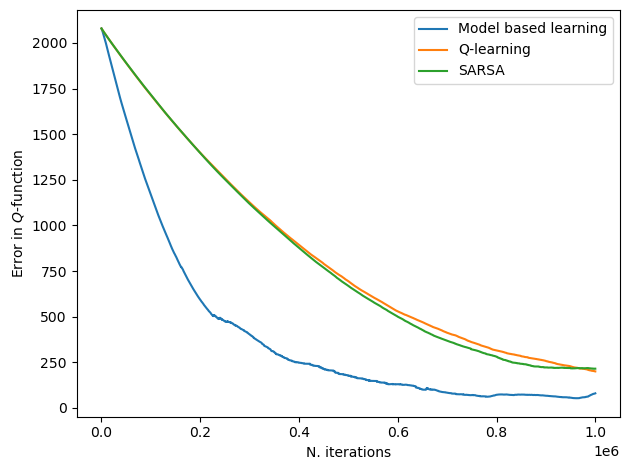

In [107]:
# Insert your code here.
def sarsa(mdp, n, qinit):
    X = mdp[0] 
    gamma = mdp[4]

    stepSize = 0.3
    Q = qinit

    # Arbitrary state chosen at random
    s = rnd.choice(len(X))
    a = egreedy(Q[s, :], eps=0.15)

    for step in range(n):
        s, a, cnew, snew = sample_transition(mdp, s, a)

        # SARSA update
        anew = egreedy(Q[snew, :], eps=0.15) # calculate next action aswell
        Q[s, a] = Q[s, a] + stepSize * (cnew + gamma * Q[snew, anew] - Q[s, a]) 

        s = snew
        a = anew

    return Q

rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = sarsa(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = sarsa(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))

import matplotlib.pyplot as plt
from tqdm import trange

STEPS = 100
ITERS = 10000
RUNS  = 1

iters = range(0, STEPS * ITERS + 1, STEPS)

# Error matrices
Emb = np.zeros(ITERS + 1)
Eql = np.zeros(ITERS + 1)
Ess = np.zeros(ITERS + 1)

Emb[0] = np.linalg.norm(Qopt) * RUNS
Eql[0] = Emb[0]
Ess[0] = Emb[0]

rnd.seed(42)

for n in range(RUNS):
    
    print('\n = Training (run n. %i) =' % n)

    # Initialization
    pmb = ()
    for a in range(len(M[1])):
        pmb += (np.eye(len(M[0])),)
    cmb = np.zeros((len(M[0]), len(M[1])))
    qmb = np.zeros((len(M[0]), len(M[1])))

    qql = np.zeros((len(M[0]), len(M[1])))

    qss = np.zeros((len(M[0]), len(M[1])))

    # Run evaluation
    for t in trange(ITERS):
        qmb, pmb, cmb = mb_learning(M, STEPS, qmb, pmb, cmb)
        Emb[t + 1] += np.linalg.norm(Qopt - qmb)

        qql = qlearning(M, STEPS, qql)
        Eql[t + 1] += np.linalg.norm(Qopt - qql)

        qss = sarsa(M, STEPS, qss)
        Ess[t + 1] += np.linalg.norm(Qopt - qss)
        
Emb /= RUNS
Eql /= RUNS
Ess /= RUNS

plt.figure()
plt.plot(iters, Emb, label='Model based learning')
plt.plot(iters, Eql, label='Q-learning')
plt.plot(iters, Ess, label='SARSA')
plt.legend()
plt.xlabel('N. iterations')
plt.ylabel('Error in $Q$-function')
plt.tight_layout()

As an example using the garbage collection MDP, we could run:

```python
rnd.seed(42)

# Initialize Q-function
qinit = np.zeros((len(M[0]), len(M[1])))

# Run 1000 steps of model-based learning
qnew = sarsa(M, 1000, qinit)

# Compare the learned Q with the optimal Q
print('Error in Q after 1000 steps:', np.linalg.norm(qnew - Qopt))

# Run 1000 additional steps of model-based learning
qnew = sarsa(M, 1000, qnew)

# Compare once again the learned Q with the optimal Q
print('Error in Q after 2000 steps:', np.linalg.norm(qnew - Qopt))
```

to get

```
Error in Q after 1000 steps: 2075.1406358460335
Error in Q after 2000 steps: 2071.3109087380585
```

You can also run the following code, to compare the performance of the three methods:

```python
%matplotlib inline

import matplotlib.pyplot as plt
from tqdm import trange

STEPS = 100
ITERS = 10000
RUNS  = 5

iters = range(0, STEPS * ITERS + 1, STEPS)

# Error matrices
Emb = np.zeros(ITERS + 1)
Eql = np.zeros(ITERS + 1)
Ess = np.zeros(ITERS + 1)

Emb[0] = np.linalg.norm(Qopt) * RUNS
Eql[0] = Emb[0]
Ess[0] = Emb[0]

rnd.seed(42)

for n in range(RUNS):
    
    print('\n = Training (run n. %i) =' % n)

    # Initialization
    pmb = ()
    for a in range(len(M[1])):
        pmb += (np.eye(len(M[0])),)
    cmb = np.zeros((len(M[0]), len(M[1])))
    qmb = np.zeros((len(M[0]), len(M[1])))

    qql = np.zeros((len(M[0]), len(M[1])))

    qss = np.zeros((len(M[0]), len(M[1])))

    # Run evaluation
    for t in trange(ITERS):
        qmb, pmb, cmb = mb_learning(M, STEPS, qmb, pmb, cmb)
        Emb[t + 1] += np.linalg.norm(Qopt - qmb)

        qql = qlearning(M, STEPS, qql)
        Eql[t + 1] += np.linalg.norm(Qopt - qql)

        qss = sarsa(M, STEPS, qss)
        Ess[t + 1] += np.linalg.norm(Qopt - qss)
        
Emb /= RUNS
Eql /= RUNS
Ess /= RUNS

plt.figure()
plt.plot(iters, Emb, label='Model based learning')
plt.plot(iters, Eql, label='Q-learning')
plt.plot(iters, Ess, label='SARSA')
plt.legend()
plt.xlabel('N. iterations')
plt.ylabel('Error in $Q$-function')
plt.tight_layout()
```

**Note:** The code above takes a while to conclude. If you want to observe faster results, you may try with a single run (set `RUNS = 1` above) or decrease the training time (changing `ITERS` above). However, the plot you will obtain will differ from the one provided.

As the output, you should observe a plot similar to the one below.

<img src="plot.png" align="left">

---

#### Activity 6.

**Based on the results you obtained when running the above code with your algorithms**, discuss the differences observed between the performance of the three methods.

---

<font color="blue">With an increase in the number of iterations, we can verify a general decrease in the error associated with the Q-function for all the algorithms above. However, one can notice a clearly better performance in the Model-based algorithm - the Q-function error decreases much faster compared to the other algorithms. The SARSA and Q-learning plots are similar, only being noticeable a small difference when the number of iterations reaches a considerable value (around 0.5e6 iterations). Considering we are applying a greedy exploration mechanism, we can state that both the SARSA (on-policy) and Q-learning (off-policy) algorithms are learning the optimal policy, the former having more stable updates. That being said, if we were to adopt a model-free learning process, we should opt for SARSA, in this specific case. On the other hand, if model-based learning is an available option, we should instead opt for it.</font>